# **SEL-NNML Tuning - Kaggle Heart Failure Prediction Dataset**

This notebook implements several tuning methods on the `Stacking Ensemble Learning with a Neural Network Meta-Learner (SEL-NNML)` model using the `Kaggle Heart Failure Prediction Dataset (KHFPD)`.

## **0. Global Configuration**

In [185]:
# Random state for reproducibility
RANDOM_STATE = 42

# Data splitting configuration
TEST_SIZE = 0.2

# Cross-validation configuration
CV_FOLDS = 5

# Hyperparameter tuning configuration
OPTIMIZATION_ITERATIONS = 100
OPTIMIZATION_METRIC = 'accuracy'
OPTIMIZATION_DIRECTION='maximize'

# Parallel processing configuration
N_JOBS = -1 

# Dataset configuration
DATASET_PATH = '../datasets/processed/ds1_kaggle_heart_clean.csv'
TARGET_COLUMN = 'HeartDisease'

# Training configuration
SKIP_TRAINING = True  # Set to True to load pre-existing models instead of training

print('Global configuration loaded successfully!')
print(f'Random State: {RANDOM_STATE}')
print(f'Test Size: {TEST_SIZE}')
print(f'CV Folds: {CV_FOLDS}')
print(f'Optimization Iterations: {OPTIMIZATION_ITERATIONS}')
print(f'Optimization Metric: {OPTIMIZATION_METRIC}')
print(f'Optimization Direction: {OPTIMIZATION_DIRECTION}')
print(f'Skip Training: {SKIP_TRAINING}')

Global configuration loaded successfully!
Random State: 42
Test Size: 0.2
CV Folds: 5
Optimization Iterations: 100
Optimization Metric: accuracy
Optimization Direction: maximize
Skip Training: True


## **1. Import Library**

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from src import base_model_tuning, meta_model_tuning
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import joblib

## **2. Load Dataset**

In [187]:
df = pd.read_csv(DATASET_PATH)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                746 non-null    int64  
 1   Sex                746 non-null    bool   
 2   RestingBP          746 non-null    int64  
 3   Cholesterol        746 non-null    int64  
 4   FastingBS          746 non-null    bool   
 5   MaxHR              746 non-null    int64  
 6   ExerciseAngina     746 non-null    bool   
 7   Oldpeak            746 non-null    float64
 8   HeartDisease       746 non-null    bool   
 9   ChestPainType_ASY  746 non-null    bool   
 10  ChestPainType_ATA  746 non-null    bool   
 11  ChestPainType_NAP  746 non-null    bool   
 12  ChestPainType_TA   746 non-null    bool   
 13  RestingECG_LVH     746 non-null    bool   
 14  RestingECG_Normal  746 non-null    bool   
 15  RestingECG_ST      746 non-null    bool   
 16  ST_Slope_Down      746 non

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,True,140,289,False,172,False,0.0,False,False,True,False,False,False,True,False,False,False,True
1,49,False,160,180,False,156,False,1.0,True,False,False,True,False,False,True,False,False,True,False
2,37,True,130,283,False,98,False,0.0,False,False,True,False,False,False,False,True,False,False,True
3,48,False,138,214,False,108,True,1.5,True,True,False,False,False,False,True,False,False,True,False
4,54,True,150,195,False,122,False,0.0,False,False,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,45,True,110,264,False,132,False,1.2,True,False,False,False,True,False,True,False,False,True,False
742,68,True,144,193,True,141,False,3.4,True,True,False,False,False,False,True,False,False,True,False
743,57,True,130,131,False,115,True,1.2,True,True,False,False,False,False,True,False,False,True,False
744,57,False,130,236,False,174,False,0.0,True,False,True,False,False,True,False,False,False,True,False


## **3. Data Preparation**

- Split the data into desired training and testing
- After that, Scaling the data using Min-Max Normalization

In [188]:
# Split dataset
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [189]:
# Min-Max Scaling
# Separate numeric and boolean columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
bool_cols = X_train.select_dtypes(include=['bool', 'uint8']).columns  # includes one-hot from get_dummies

# Initialize scaler and fit_transform only on numeric data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index)

# Concatenate back with boolean features (without modification)
X_train = pd.concat([X_train_scaled, X_train[bool_cols]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[bool_cols]], axis=1)

# Save Min-Max Scaler
scaler_filename = '../artifacts/ds1/models/min_max_scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f'Saved Min-Max Scaler function for this dataset to {scaler_filename}')

Saved Min-Max Scaler function for this dataset to ../artifacts/ds1/models/min_max_scaler.pkl


## **4. Base Model Hyperparameter Tuning**

**Note:** Set `SKIP_TRAINING = True` in the global configuration to skip steps 4 and 5 and load pre-existing models instead.

### **4.1 TPE & CV Hyperparameter Tuning**

In [190]:
if not SKIP_TRAINING:
    tpe_base_models_training_start = time.time()

    # TPE Hyperparameter Tuning with Cross Validation
    tpe_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    tpe_logistic_regression.fit(X_train, y_train)
    tpe_decision_tree.fit(X_train, y_train)
    tpe_random_forest.fit(X_train, y_train)
    tpe_knn.fit(X_train, y_train)
    tpe_svc.fit(X_train, y_train)
    tpe_adaboost.fit(X_train, y_train)
    tpe_gradient_boosting.fit(X_train, y_train)

    tpe_base_models_training_end = time.time()

    # Time taken for TPE base models training
    tpe_base_models_training_time = tpe_base_models_training_end - tpe_base_models_training_start
    print(f'TPE Base Models Training Time: {tpe_base_models_training_time:.2f} seconds')
else:
    print("Skipping TPE base models training (SKIP_TRAINING = True)")

Skipping TPE base models training (SKIP_TRAINING = True)


### **4.2 GP & CV Hyperparameter Tuning**

In [191]:
if not SKIP_TRAINING:
    gp_base_models_training_start = time.time()

    # GP Hyperparameter Tuning with Cross Validation
    gp_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    gp_logistic_regression.fit(X_train, y_train)
    gp_decision_tree.fit(X_train, y_train)
    gp_random_forest.fit(X_train, y_train)
    gp_knn.fit(X_train, y_train)
    gp_svc.fit(X_train, y_train)
    gp_adaboost.fit(X_train, y_train)
    gp_gradient_boosting.fit(X_train, y_train)

    gp_base_models_training_end = time.time()

    # Time taken for GP base models training
    gp_base_models_training_time = gp_base_models_training_end - gp_base_models_training_start
    print(f'GP Base Models Training Time: {gp_base_models_training_time:.2f} seconds')
else:
    print("Skipping GP base models training (SKIP_TRAINING = True)")

Skipping GP base models training (SKIP_TRAINING = True)


### **4.3 CMA-ES & CV Hyperparameter Tuning**

In [192]:
if not SKIP_TRAINING:
    cmaes_base_models_training_start = time.time()

    # CMA-ES Hyperparameter Tuning with Cross Validation
    cmaes_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    cmaes_logistic_regression.fit(X_train, y_train)
    cmaes_decision_tree.fit(X_train, y_train)
    cmaes_random_forest.fit(X_train, y_train)
    cmaes_knn.fit(X_train, y_train)
    cmaes_svc.fit(X_train, y_train)
    cmaes_adaboost.fit(X_train, y_train)
    cmaes_gradient_boosting.fit(X_train, y_train)

    cmaes_base_models_training_end = time.time()

    # Time taken for CMA-ES base models training
    cmaes_base_models_training_time = cmaes_base_models_training_end - cmaes_base_models_training_start
    print(f'CMA-ES Base Models Training Time: {cmaes_base_models_training_time:.2f} seconds')
else:
    print("Skipping CMA-ES base models training (SKIP_TRAINING = True)")

Skipping CMA-ES base models training (SKIP_TRAINING = True)


### **4.4 QMC & CV Hyperparameter Tuning**

In [193]:
if not SKIP_TRAINING:
    qmc_base_models_training_start = time.time()

    # QMC Hyperparameter Tuning with Cross Validation
    qmc_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    qmc_logistic_regression.fit(X_train, y_train)
    qmc_decision_tree.fit(X_train, y_train)
    qmc_random_forest.fit(X_train, y_train)
    qmc_knn.fit(X_train, y_train)
    qmc_svc.fit(X_train, y_train)
    qmc_adaboost.fit(X_train, y_train)
    qmc_gradient_boosting.fit(X_train, y_train)

    qmc_base_models_training_end = time.time()

    # Time taken for QMC base models training
    qmc_base_models_training_time = qmc_base_models_training_end - qmc_base_models_training_start
    print(f'QMC Base Models Training Time: {qmc_base_models_training_time:.2f} seconds')
else:
    print("Skipping QMC base models training (SKIP_TRAINING = True)")

Skipping QMC base models training (SKIP_TRAINING = True)


### **4.5 Save Every Best Model Config for each Tuning Method**

In [194]:
if not SKIP_TRAINING:
    # Base Models Storage for all sampler types
    base_models = {
        'TPE': {
            'Logistic Regression': tpe_logistic_regression,
            'Decision Tree': tpe_decision_tree,
            'Random Forest': tpe_random_forest,
            'K-Nearest Neighbors': tpe_knn,
            'Support Vector Machine': tpe_svc,
            'AdaBoost': tpe_adaboost,
            'Gradient Boosting': tpe_gradient_boosting
        },
        'GP': {
            'Logistic Regression': gp_logistic_regression,
            'Decision Tree': gp_decision_tree,
            'Random Forest': gp_random_forest,
            'K-Nearest Neighbors': gp_knn,
            'Support Vector Machine': gp_svc,
            'AdaBoost': gp_adaboost,
            'Gradient Boosting': gp_gradient_boosting
        },
        'CMA-ES': {
            'Logistic Regression': cmaes_logistic_regression,
            'Decision Tree': cmaes_decision_tree,
            'Random Forest': cmaes_random_forest,
            'K-Nearest Neighbors': cmaes_knn,
            'Support Vector Machine': cmaes_svc,
            'AdaBoost': cmaes_adaboost,
            'Gradient Boosting': cmaes_gradient_boosting
        },
        'QMC': {
            'Logistic Regression': qmc_logistic_regression,
            'Decision Tree': qmc_decision_tree,
            'Random Forest': qmc_random_forest,
            'K-Nearest Neighbors': qmc_knn,
            'Support Vector Machine': qmc_svc,
            'AdaBoost': qmc_adaboost,
            'Gradient Boosting': qmc_gradient_boosting
        }
    }
else:
    print("Skipping base models storage (SKIP_TRAINING = True)")

Skipping base models storage (SKIP_TRAINING = True)


## **5. Meta Model Hyperparameter Tuning**

The hyperparameters to be tuned are:
- Selection of the number and type of base models used
- Number of layers in the neural network: 1 - 5
- Number of neurons per layer: 10 - 100
- Learning rate behavior: Constant or Adaptive
- Learning rate value: 0.0001 - 0.01
- L2 Regularization value: 0.0001 - 0.01

Unchanged Preset hyperparameters:
- Activation function: ReLU
- Optimizer (Solver): Adam
- Epochs (Max Iter): 300

### **4.1 TPE Hyperparameter Tuning**

In [195]:
if not SKIP_TRAINING:
    tpe_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    tpe_sel_nnml, tpe_meta_study = meta_model_tuning(base_models['TPE'], X_train, y_train, X_test, y_test, sampler='TPESampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_sel_nnml.fit(X_train, y_train)

    tpe_meta_model_training_end = time.time()

    # Time taken for TPE SEl-NNML training
    tpe_meta_model_training_time = tpe_meta_model_training_end - tpe_meta_model_training_start
    print(f'TPE base models training time: {tpe_base_models_training_time:.2f} seconds')
    print(f'TPE SEl-NNML Training Time: {tpe_meta_model_training_time:.2f} seconds')
    print(f'Total TPE Training Time (Base + Meta): {tpe_base_models_training_time + tpe_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    tpe_meta_history = tpe_meta_study.trials_dataframe()[['number', 'value']].copy()
    tpe_meta_history.columns = ['iteration', 'score']
    tpe_meta_history['iteration'] = tpe_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping TPE meta model training (SKIP_TRAINING = True)")

Skipping TPE meta model training (SKIP_TRAINING = True)


### **4.2 GP & CV Hyperparameter Tuning**

In [196]:
if not SKIP_TRAINING:
    gp_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    gp_sel_nnml, gp_meta_study = meta_model_tuning(base_models['GP'], X_train, y_train, X_test, y_test, sampler='GPSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_sel_nnml.fit(X_train, y_train)

    gp_meta_model_training_end = time.time()

    # Time taken for GP SEl-NNML training
    gp_meta_model_training_time = gp_meta_model_training_end - gp_meta_model_training_start
    print(f'GP base models training time: {gp_base_models_training_time:.2f} seconds')
    print(f'GP SEl-NNML Training Time: {gp_meta_model_training_time:.2f} seconds')
    print(f'Total GP Training Time (Base + Meta): {gp_base_models_training_time + gp_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    gp_meta_history = gp_meta_study.trials_dataframe()[['number', 'value']].copy()
    gp_meta_history.columns = ['iteration', 'score']
    gp_meta_history['iteration'] = gp_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping GP meta model training (SKIP_TRAINING = True)")

Skipping GP meta model training (SKIP_TRAINING = True)


### **4.3 CMA-ES & CV Hyperparameter Tuning**

In [197]:
if not SKIP_TRAINING:
    cmaes_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    cmaes_sel_nnml, cmaes_meta_study = meta_model_tuning(base_models['CMA-ES'], X_train, y_train, X_test, y_test, sampler='CmaEsSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE) 
    cmaes_sel_nnml.fit(X_train, y_train)

    cmaes_meta_model_training_end = time.time()

    # Time taken for CMA-ES SEl-NNML training
    cmaes_meta_model_training_time = cmaes_meta_model_training_end - cmaes_meta_model_training_start
    print(f'CMA-ES base models training time: {cmaes_base_models_training_time:.2f} seconds')
    print(f'CMA-ES SEl-NNML Training Time: {cmaes_meta_model_training_time:.2f} seconds')
    print(f'Total CMA-ES Training Time (Base + Meta): {cmaes_base_models_training_time + cmaes_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    cmaes_meta_history = cmaes_meta_study.trials_dataframe()[['number', 'value']].copy()
    cmaes_meta_history.columns = ['iteration', 'score']
    cmaes_meta_history['iteration'] = cmaes_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping CMA-ES meta model training (SKIP_TRAINING = True)")

Skipping CMA-ES meta model training (SKIP_TRAINING = True)


### **4.4 QMC & CV Hyperparameter Tuning**

In [198]:
if not SKIP_TRAINING:
    qmc_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    qmc_sel_nnml, qmc_meta_study = meta_model_tuning(base_models['QMC'], X_train, y_train, X_test, y_test, sampler='QMCSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_sel_nnml.fit(X_train, y_train)

    qmc_meta_model_training_end = time.time()

    # Time taken for QMC SEl-NNML training
    qmc_meta_model_training_time = qmc_meta_model_training_end - qmc_meta_model_training_start
    print(f'QMC base models training time: {qmc_base_models_training_time:.2f} seconds')
    print(f'QMC SEl-NNML Training Time: {qmc_meta_model_training_time:.2f} seconds')
    print(f'Total QMC Training Time (Base + Meta): {qmc_base_models_training_time + qmc_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    qmc_meta_history = qmc_meta_study.trials_dataframe()[['number', 'value']].copy()
    qmc_meta_history.columns = ['iteration', 'score']
    qmc_meta_history['iteration'] = qmc_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping QMC meta model training (SKIP_TRAINING = True)")

Skipping QMC meta model training (SKIP_TRAINING = True)


In [199]:
if not SKIP_TRAINING:
    import os
    
    # All Models Storage for all sampler types
    all_models = {
        'TPE': {
            'Logistic Regression': tpe_logistic_regression,
            'Decision Tree': tpe_decision_tree,
            'Random Forest': tpe_random_forest,
            'K-Nearest Neighbors': tpe_knn,
            'Support Vector Machine': tpe_svc,
            'AdaBoost': tpe_adaboost,
            'Gradient Boosting': tpe_gradient_boosting,
            'SEL-NNML': tpe_sel_nnml
        },
        'GP': {
            'Logistic Regression': gp_logistic_regression,
            'Decision Tree': gp_decision_tree,
            'Random Forest': gp_random_forest,
            'K-Nearest Neighbors': gp_knn,
            'Support Vector Machine': gp_svc,
            'AdaBoost': gp_adaboost,
            'Gradient Boosting': gp_gradient_boosting,
            'SEL-NNML': gp_sel_nnml
        },
        'CMA-ES': {
            'Logistic Regression': cmaes_logistic_regression,
            'Decision Tree': cmaes_decision_tree,
            'Random Forest': cmaes_random_forest,
            'K-Nearest Neighbors': cmaes_knn,
            'Support Vector Machine': cmaes_svc,
            'AdaBoost': cmaes_adaboost,
            'Gradient Boosting': cmaes_gradient_boosting,
            'SEL-NNML': cmaes_sel_nnml
        },
        'QMC': {
            'Logistic Regression': qmc_logistic_regression,
            'Decision Tree': qmc_decision_tree,
            'Random Forest': qmc_random_forest,
            'K-Nearest Neighbors': qmc_knn,
            'Support Vector Machine': qmc_svc,
            'AdaBoost': qmc_adaboost,
            'Gradient Boosting': qmc_gradient_boosting,
            'SEL-NNML': qmc_sel_nnml
        }
    }

    # Save Every Best Model Config for each Tuning Method (Base + Meta) as CSV
    all_model_hyperparameters = []
    for sampler, models in all_models.items():
        for model_name, model in models.items():
            # Some meta models (e.g., stacking) may not have get_params, handle gracefully
            params = model.get_params() if hasattr(model, 'get_params') else None
            all_model_hyperparameters.append({
                'Sampler': sampler,
                'Model Name': model_name,
                'Best Hyperparameters': params
            })
    all_model_hyperparameters_df = pd.DataFrame(all_model_hyperparameters)
    
    # Ensure directory exists
    os.makedirs('../artifacts/ds1/models', exist_ok=True)
    
    all_model_hyperparameters_df.to_csv('../artifacts/ds1/models/all_model_hyperparameters.csv', index=False)

    # Show All Model Hyperparameters for all samplers
    display(all_model_hyperparameters_df)
else:
    print("Skipping model storage (SKIP_TRAINING = True)")

Skipping model storage (SKIP_TRAINING = True)


In [200]:
if not SKIP_TRAINING:
    import os
    
    # Save Every Best Meta Model for each Tuning Method as .pkl
    for sampler, models in all_models.items():
        folder = sampler.lower().replace("-", "")
        # Ensure directory exists
        os.makedirs(f'../artifacts/ds1/models/{folder}', exist_ok=True)
        
        for model_name, model in models.items():
            filename = f'../artifacts/ds1/models/{folder}/{model_name.replace(" ", "_").lower()}_best_model.pkl'
            joblib.dump(model, filename)
            print(f'Saved {model_name} model tuned with {sampler} to {filename}')
else:
    print("Skipping model saving (SKIP_TRAINING = True)")

Skipping model saving (SKIP_TRAINING = True)


In [201]:
if not SKIP_TRAINING:
    import os
    
    # SAVE TRAIN TIME FOR EACH SAMPLER TYPE (BASE + META) IN A FILE
    train_times = {
        'Sampler': ['TPE', 'GP', 'CMA-ES', 'QMC'],
        'Base Models Training Time (seconds)': [
            tpe_base_models_training_time,
            gp_base_models_training_time,
            cmaes_base_models_training_time,
            qmc_base_models_training_time
        ],
        'Meta Model Training Time (seconds)': [
            tpe_meta_model_training_time,
            gp_meta_model_training_time,
            cmaes_meta_model_training_time,
            qmc_meta_model_training_time
        ],
        'Total Training Time (seconds)': [
            tpe_base_models_training_time + tpe_meta_model_training_time,
            gp_base_models_training_time + gp_meta_model_training_time,
            cmaes_base_models_training_time + cmaes_meta_model_training_time,
            qmc_base_models_training_time + qmc_meta_model_training_time
        ]
    }

    train_times_df = pd.DataFrame(train_times)
    
    # Ensure directory exists
    os.makedirs('../artifacts/ds1/models', exist_ok=True)
    
    train_times_df.to_csv('../artifacts/ds1/models/training_times.csv', index=False)
    display(train_times_df)
else:
    print("Skipping training times saving (SKIP_TRAINING = True)")

Skipping training times saving (SKIP_TRAINING = True)


In [202]:
if not SKIP_TRAINING:
    # SAVE SEL-NNML TRAINING HISTORY (CONVERGENCE DATA) FOR EACH SAMPLER
    # These will be used to create convergence plots showing how the model performance
    # improved over the 100 optimization iterations
    
    import os
    
    # Ensure directories exist for each sampler
    samplers = ['tpe', 'gp', 'cmaes', 'qmc']
    for sampler in samplers:
        os.makedirs(f'../artifacts/ds1/models/{sampler}', exist_ok=True)
    
    # Save TPE SEL-NNML training history
    tpe_meta_history.to_csv('../artifacts/ds1/models/tpe/sel-nnml_training_history.csv', index=False)
    print(f'Saved TPE SEL-NNML training history to ../artifacts/ds1/models/tpe/sel-nnml_training_history.csv')
    
    # Save GP SEL-NNML training history
    gp_meta_history.to_csv('../artifacts/ds1/models/gp/sel-nnml_training_history.csv', index=False)
    print(f'Saved GP SEL-NNML training history to ../artifacts/ds1/models/gp/sel-nnml_training_history.csv')
    
    # Save CMA-ES SEL-NNML training history
    cmaes_meta_history.to_csv('../artifacts/ds1/models/cmaes/sel-nnml_training_history.csv', index=False)
    print(f'Saved CMA-ES SEL-NNML training history to ../artifacts/ds1/models/cmaes/sel-nnml_training_history.csv')
    
    # Save QMC SEL-NNML training history
    qmc_meta_history.to_csv('../artifacts/ds1/models/qmc/sel-nnml_training_history.csv', index=False)
    print(f'Saved QMC SEL-NNML training history to ../artifacts/ds1/models/qmc/sel-nnml_training_history.csv')
    
    # Display a sample of one history to verify the data
    print("\nSample of TPE SEL-NNML Training History (first 10 iterations):")
    display(tpe_meta_history.head(10))
else:
    print("Skipping SEL-NNML training history saving (SKIP_TRAINING = True)")

Skipping SEL-NNML training history saving (SKIP_TRAINING = True)


In [203]:
# Skip step 4 and load every best model for each tuning method if SKIP_TRAINING is True
if SKIP_TRAINING:
    print("Loading pre-existing models...")
    all_models = {sampler: {
            'Logistic Regression': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/logistic_regression_best_model.pkl'),
            'Decision Tree': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/decision_tree_best_model.pkl'),
            'Random Forest': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/random_forest_best_model.pkl'),
            'K-Nearest Neighbors': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/k-nearest_neighbors_best_model.pkl'),
            'Support Vector Machine': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/support_vector_machine_best_model.pkl'),
            'AdaBoost': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/adaboost_best_model.pkl'),
            'Gradient Boosting': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/gradient_boosting_best_model.pkl'),
            'SEL-NNML': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/sel-nnml_best_model.pkl')
        } for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']}
    print("All models loaded successfully!")
    
    # Load training times
    print("Loading training times...")
    train_times_df = pd.read_csv('../artifacts/ds1/models/training_times.csv')
    
    # Extract individual training times for each sampler
    for idx, row in train_times_df.iterrows():
        sampler = row['Sampler']
        if sampler == 'TPE':
            tpe_base_models_training_time = row['Base Models Training Time (seconds)']
            tpe_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'GP':
            gp_base_models_training_time = row['Base Models Training Time (seconds)']
            gp_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'CMA-ES':
            cmaes_base_models_training_time = row['Base Models Training Time (seconds)']
            cmaes_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'QMC':
            qmc_base_models_training_time = row['Base Models Training Time (seconds)']
            qmc_meta_model_training_time = row['Meta Model Training Time (seconds)']
    
    print("Training times loaded successfully!")
    display(train_times_df)
    
    # Load SEL-NNML training histories for convergence plots
    print("\nLoading SEL-NNML training histories...")
    tpe_meta_history = pd.read_csv('../artifacts/ds1/models/tpe/sel-nnml_training_history.csv')
    gp_meta_history = pd.read_csv('../artifacts/ds1/models/gp/sel-nnml_training_history.csv')
    cmaes_meta_history = pd.read_csv('../artifacts/ds1/models/cmaes/sel-nnml_training_history.csv')
    qmc_meta_history = pd.read_csv('../artifacts/ds1/models/qmc/sel-nnml_training_history.csv')
    print("SEL-NNML training histories loaded successfully!")
else:
    print("SKIP_TRAINING is False. Models should be trained in steps 4 and 5.")

Loading pre-existing models...


All models loaded successfully!
Loading training times...
Training times loaded successfully!


,Sampler,Base Models Training Time (seconds),Meta Model Training Time (seconds),Total Training Time (seconds)
0,TPE,79.417850,204.344396,283.762246
1,GP,245.867975,180.600049,426.468023
2,CMA-ES,51.052620,92.664979,143.717600
3,QMC,50.219519,116.230495,166.450014



Loading SEL-NNML training histories...
SEL-NNML training histories loaded successfully!


## **6. Model Evaluation**

This stage contains model evaluation on the test set, with details as follows:
- `plot_evaluation_metrics()`: Shows the confusion matrix graph & scores for accuracy, precision, recall, and F1-Score
- `Model Performance Comparison Plot`: Displays accuracy, precision, recall, F1-Score, and ROC AUC scores
- `overfitting_index_plot()`: Shows the percentage of the difference between model scores on test data versus training data

In [204]:
# Single Model Evaluation Dashboard
def evaluation_metrics_plot(y_true, y_pred):
    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
    }
    metric_order = ['F1-Score', 'Recall', 'Precision', 'Accuracy']
    values = [metrics[name] for name in metric_order]

    fig = plt.figure(figsize=(10, 8))
    cm_pos = [0.08, 0.15, 0.53, 0.7]
    metrics_pos = [0.75, 0.15, 0.21, 0.7]

    # Confusion Matrix
    ax_cm = fig.add_axes(cm_pos)
    im = ax_cm.imshow(cm, cmap='Blues', interpolation='nearest', aspect='equal')
    cbar_ax = fig.add_axes([cm_pos[0] + cm_pos[2] + 0.02, cm_pos[1], 0.02, cm_pos[3]])
    fig.colorbar(im, cax=cbar_ax).ax.tick_params(labelsize=16)

    cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count, pct = int(cm[i, j]), cm_pct[i, j]
            color = 'white' if count > cm.max() / 2 else 'black'
            ax_cm.text(j, i, f'{count}\n({pct:.1f}%)', ha='center', va='center',
                    color=color, fontsize=18, fontweight='bold', linespacing=1.1)

    ax_cm.set_xticks([0, 1])
    ax_cm.set_yticks([0, 1])
    ax_cm.set_xticklabels(['No\n(0)', 'Disease\n(1)'], fontsize=16)
    ax_cm.set_yticklabels(['No (0)', 'Disease (1)'], fontsize=16, rotation=90, va='center')
    ax_cm.set_xlabel('Predicted', fontsize=16, fontweight='bold')
    ax_cm.set_ylabel('Actual', fontsize=16, fontweight='bold')
    ax_cm.set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=10)
    ax_cm.set_ylim(1.5, -0.5)

    # Metrics Bar
    ax_metrics = fig.add_axes(metrics_pos)
    y_positions = np.arange(len(metric_order)) * 2
    bars = ax_metrics.barh(y_positions, values, height=0.8, color='#31688E', alpha=0.8)

    for bar, value in zip(bars, values):
        color = 'white' if value > 0.5 else 'black'
        x_pos = value - 0.02 if value > 0.5 else value + 0.02
        ha = 'right' if value > 0.5 else 'left'
        ax_metrics.text(x_pos, bar.get_y() + bar.get_height()/2, f'{value:.3f}',
                        ha=ha, va='center', fontsize=18, fontweight='bold', color=color)

    ax_metrics.set_xlim(-0.05, 1.05)
    ax_metrics.set_ylim(-0.8, len(metric_order) * 2 - 0.2)
    ax_metrics.set_xticks([0, 0.5, 1.0])
    ax_metrics.set_xticklabels(['0.0', '0.5', '1.0'], fontsize=16)
    ax_metrics.set_yticks(y_positions)
    ax_metrics.set_yticklabels(metric_order, fontsize=16, rotation=90, ha='left', va='center')
    ax_metrics.tick_params(axis='y', pad=15)
    ax_metrics.tick_params(axis='x', pad=8)
    ax_metrics.set_xlabel('Score', fontsize=16, fontweight='bold')
    ax_metrics.set_title('Performance Metrics', fontsize=16, fontweight='bold', pad=10)
    ax_metrics.grid(axis='x', alpha=0.3, linestyle='--')
    for spine in ['top', 'right', 'left']:
        ax_metrics.spines[spine].set_visible(False)
    ax_metrics.spines['bottom'].set_alpha(0.5)

    plt.show()


In [205]:
# Multiple Model Comparison Dashboard (for comparing all models)
def model_comparison_plot(models, x_test, y_test):
    metrics = {
        'Model': [],
        'Accuracy': [],
        'F1-Score': [],
        'Precision': [],
        'Recall': [],
        'AUC': []
    }
    
    # Map full names to short names
    short_names = {
        'Logistic Regression': 'LR',
        'Decision Tree': 'DT',
        'Random Forest': 'RF',
        'K-Nearest Neighbors': 'KNN',
        'Support Vector Machine': 'SVM',
        'AdaBoost': 'AdaBoost',
        'Gradient Boosting': 'Gradient Boosting',
        'SEL-NNML': 'SEL-NNML'
    }
    
    # Calculate metrics for each model
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        metrics['Model'].append(short_names[model_name])
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['F1-Score'].append(f1_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred))
        metrics['Recall'].append(recall_score(y_test, y_pred))
        
        # Calculate AUC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        metrics['AUC'].append(roc_auc)
    
    # Convert metrics to DataFrame for sorting
    metrics_df = pd.DataFrame(metrics)
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold') 
    
    # Helper function to plot sorted bar charts
    def plot_sorted_bar_chart(ax, metric_name):
        sorted_df = metrics_df.sort_values(by=metric_name, ascending=False)
        colors = ['tab:orange' if model == 'SEL-NNML' else 'tab:blue' for model in sorted_df['Model']]
        ax.bar(sorted_df['Model'], sorted_df[metric_name], color=colors)
        ax.set_title(metric_name)
        ax.set_ylabel('Score')
        ax.set_ylim([0, 1])
        ax.set_xticks(range(len(sorted_df['Model'])))
        ax.set_xticklabels(sorted_df['Model'], rotation=30, ha='center')
        for i, v in enumerate(sorted_df[metric_name]):
            ax.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Plot each metric
    plot_sorted_bar_chart(axes[0, 0], 'Accuracy')
    plot_sorted_bar_chart(axes[0, 1], 'F1-Score')
    plot_sorted_bar_chart(axes[1, 0], 'Precision')
    plot_sorted_bar_chart(axes[1, 1], 'Recall')
    
    # ROC Curve
    ax_roc = axes[2, 0]
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=2, label=f'{short_names[model_name]} (AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_title('Receiver Operating Characteristic')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc="lower right")
    
    # Bar chart for AUC
    plot_sorted_bar_chart(axes[2, 1], 'AUC')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [206]:
def overfitting_index_plot(all_models, x_train, y_train, x_test, y_test):
    metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    overfitting_indices = {metric: [] for metric in metrics}

    for _, model in all_models.items():
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        overfitting_indices['Accuracy'].append(abs(accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_test_pred)) / accuracy_score(y_train, y_train_pred) * 100)
        overfitting_indices['F1-Score'].append(abs(f1_score(y_train, y_train_pred) - f1_score(y_test, y_test_pred)) / f1_score(y_train, y_train_pred) * 100)
        overfitting_indices['Precision'].append(abs(precision_score(y_train, y_train_pred) - precision_score(y_test, y_test_pred)) / precision_score(y_train, y_train_pred) * 100)
        overfitting_indices['Recall'].append(abs(recall_score(y_train, y_train_pred) - recall_score(y_test, y_test_pred)) / recall_score(y_train, y_train_pred) * 100)

    overfitting_df = pd.DataFrame(overfitting_indices, index=all_models.keys())

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Overfitting Index for All Metrics', fontsize=16, fontweight='bold')

    def get_bar_colors(models, highlight_model='SEL-NNML', default_color='tab:blue', highlight_color='tab:orange'):
        return [highlight_color if model == highlight_model else default_color for model in models]

    # Accuracy
    overfitting_df_sorted = overfitting_df.sort_values(by='Accuracy', ascending=False)
    axes[0, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Accuracy'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 0].set_title('Accuracy Overfitting Index')
    axes[0, 0].set_ylabel('Overfitting Index (%)')
    axes[0, 0].set_ylim([0, 100])
    axes[0, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Accuracy']):
        axes[0, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # F1-Score
    overfitting_df_sorted = overfitting_df.sort_values(by='F1-Score', ascending=False)
    axes[0, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['F1-Score'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 1].set_title('F1-Score Overfitting Index')
    axes[0, 1].set_ylabel('Overfitting Index (%)')
    axes[0, 1].set_ylim([0, 100])
    axes[0, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['F1-Score']):
        axes[0, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    # Precision
    overfitting_df_sorted = overfitting_df.sort_values(by='Precision', ascending=False)
    axes[1, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Precision'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 0].set_title('Precision Overfitting Index')
    axes[1, 0].set_ylabel('Overfitting Index (%)')
    axes[1, 0].set_ylim([0, 100])
    axes[1, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Precision']):
        axes[1, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # Recall
    overfitting_df_sorted = overfitting_df.sort_values(by='Recall', ascending=False)
    axes[1, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['Recall'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 1].set_title('Recall Overfitting Index')
    axes[1, 1].set_ylabel('Overfitting Index (%)')
    axes[1, 1].set_ylim([0, 100])
    axes[1, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Recall']):
        axes[1, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### **6.1 SEL-NNML Model Evaluation**

This section evaluates the SEL-NNML model from the selected sampler. Change `SELECTED_SAMPLER` in the cell below to evaluate a different sampler's SEL-NNML model.

In [207]:
# Select which sampler's models to evaluate
# Options: 'TPE', 'GP', 'CMA-ES', 'QMC'
SELECTED_SAMPLER = 'TPE'

# Extract models and training times for the selected sampler
selected_models = all_models[SELECTED_SAMPLER]
sel_nnml = selected_models['SEL-NNML']

# Extract training times for the selected sampler
if SELECTED_SAMPLER == 'TPE':
    base_models_training_time = tpe_base_models_training_time
    meta_model_training_time = tpe_meta_model_training_time
elif SELECTED_SAMPLER == 'GP':
    base_models_training_time = gp_base_models_training_time
    meta_model_training_time = gp_meta_model_training_time
elif SELECTED_SAMPLER == 'CMA-ES':
    base_models_training_time = cmaes_base_models_training_time
    meta_model_training_time = cmaes_meta_model_training_time
elif SELECTED_SAMPLER == 'QMC':
    base_models_training_time = qmc_base_models_training_time
    meta_model_training_time = qmc_meta_model_training_time

print(f'Selected sampler: {SELECTED_SAMPLER}')
print(f'Models available: {list(selected_models.keys())}')

Selected sampler: TPE
Models available: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbors', 'Support Vector Machine', 'AdaBoost', 'Gradient Boosting', 'SEL-NNML']


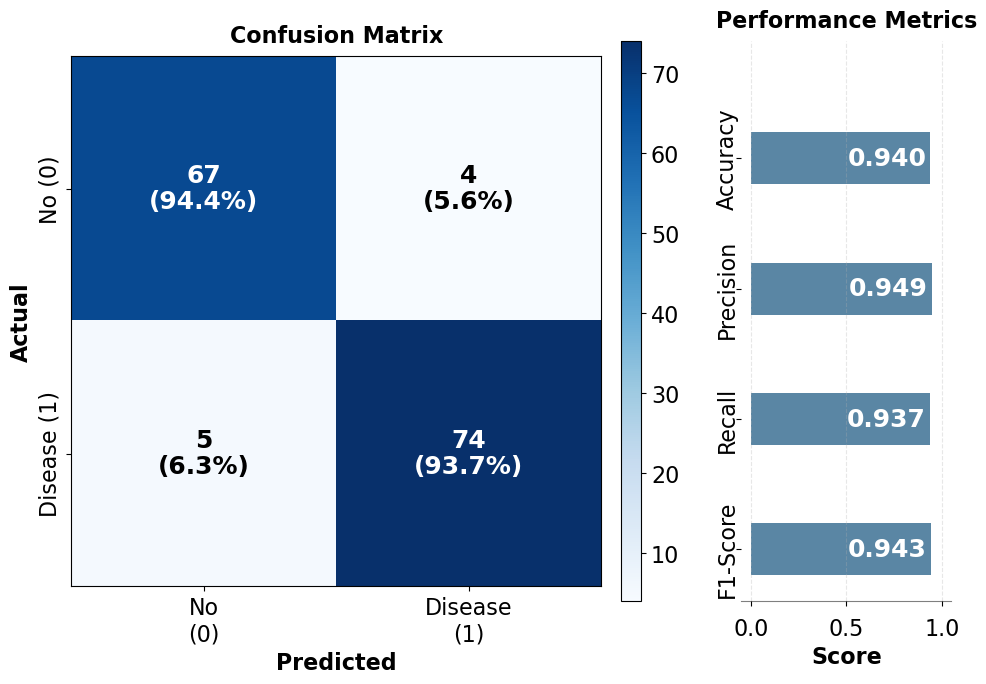

In [208]:
# Show SEL-NNML Evaluation Metrics
y_pred_stack = sel_nnml.predict(X_test)
evaluation_metrics_plot(y_test, y_pred_stack)

In [209]:
# Show SEL-NNM: all fold scores with mean and std 
sel_nnml_cv_scores = cross_val_score(sel_nnml, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=N_JOBS)
print(f'SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: {sel_nnml_cv_scores}')
print(f'Mean: {sel_nnml_cv_scores.mean():.4f}')
print(f'Standard Deviation: {sel_nnml_cv_scores.std():.4f}')

SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: [0.84166667 0.85714286 0.88235294 0.82352941 0.86554622]
Mean: 0.8540
Standard Deviation: 0.0201


In [210]:
# Show SELL-NNML Training Time
Total_training_time = base_models_training_time + meta_model_training_time
print(f'Base Models Tuning & Training Time: {base_models_training_time:.2f} seconds')
print(f'Meta Model Tuning & Training Time: {meta_model_training_time:.2f} seconds')
print(f'Total SEL-NNML Tuning & Training Time: {Total_training_time:.2f} seconds')

Base Models Tuning & Training Time: 79.42 seconds
Meta Model Tuning & Training Time: 204.34 seconds
Total SEL-NNML Tuning & Training Time: 283.76 seconds


### **6.2 Multiple Model Evaluation**

The evaluation below compares all models (base models + SEL-NNML) for the selected sampler. To compare models across different samplers, change the `SELECTED_SAMPLER` variable in the cell above.

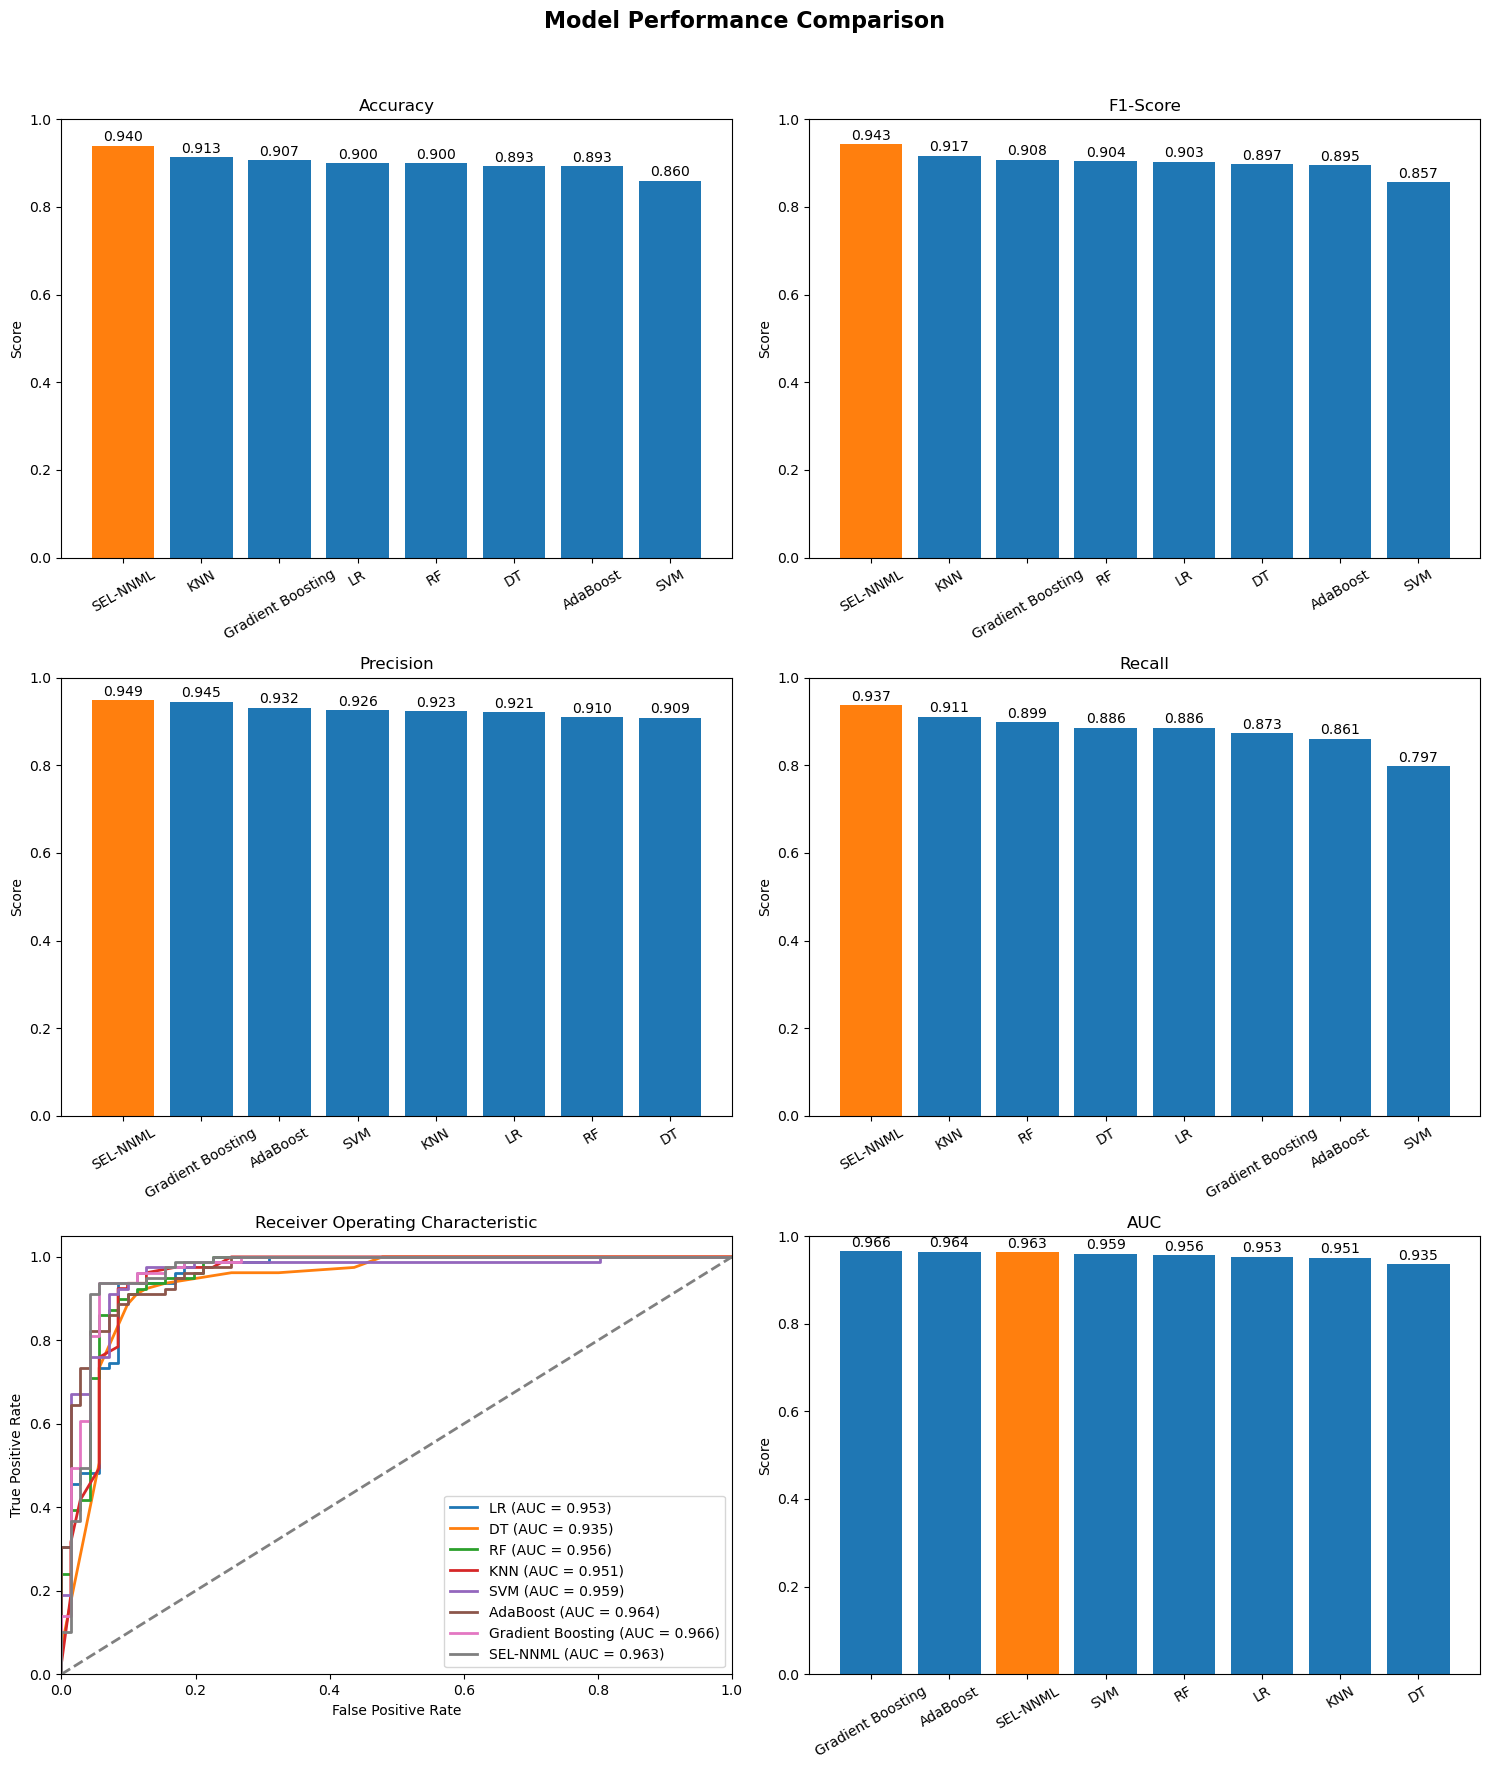

In [211]:
# Use the selected sampler's models for comparison
model_comparison_plot(selected_models, X_test, y_test)

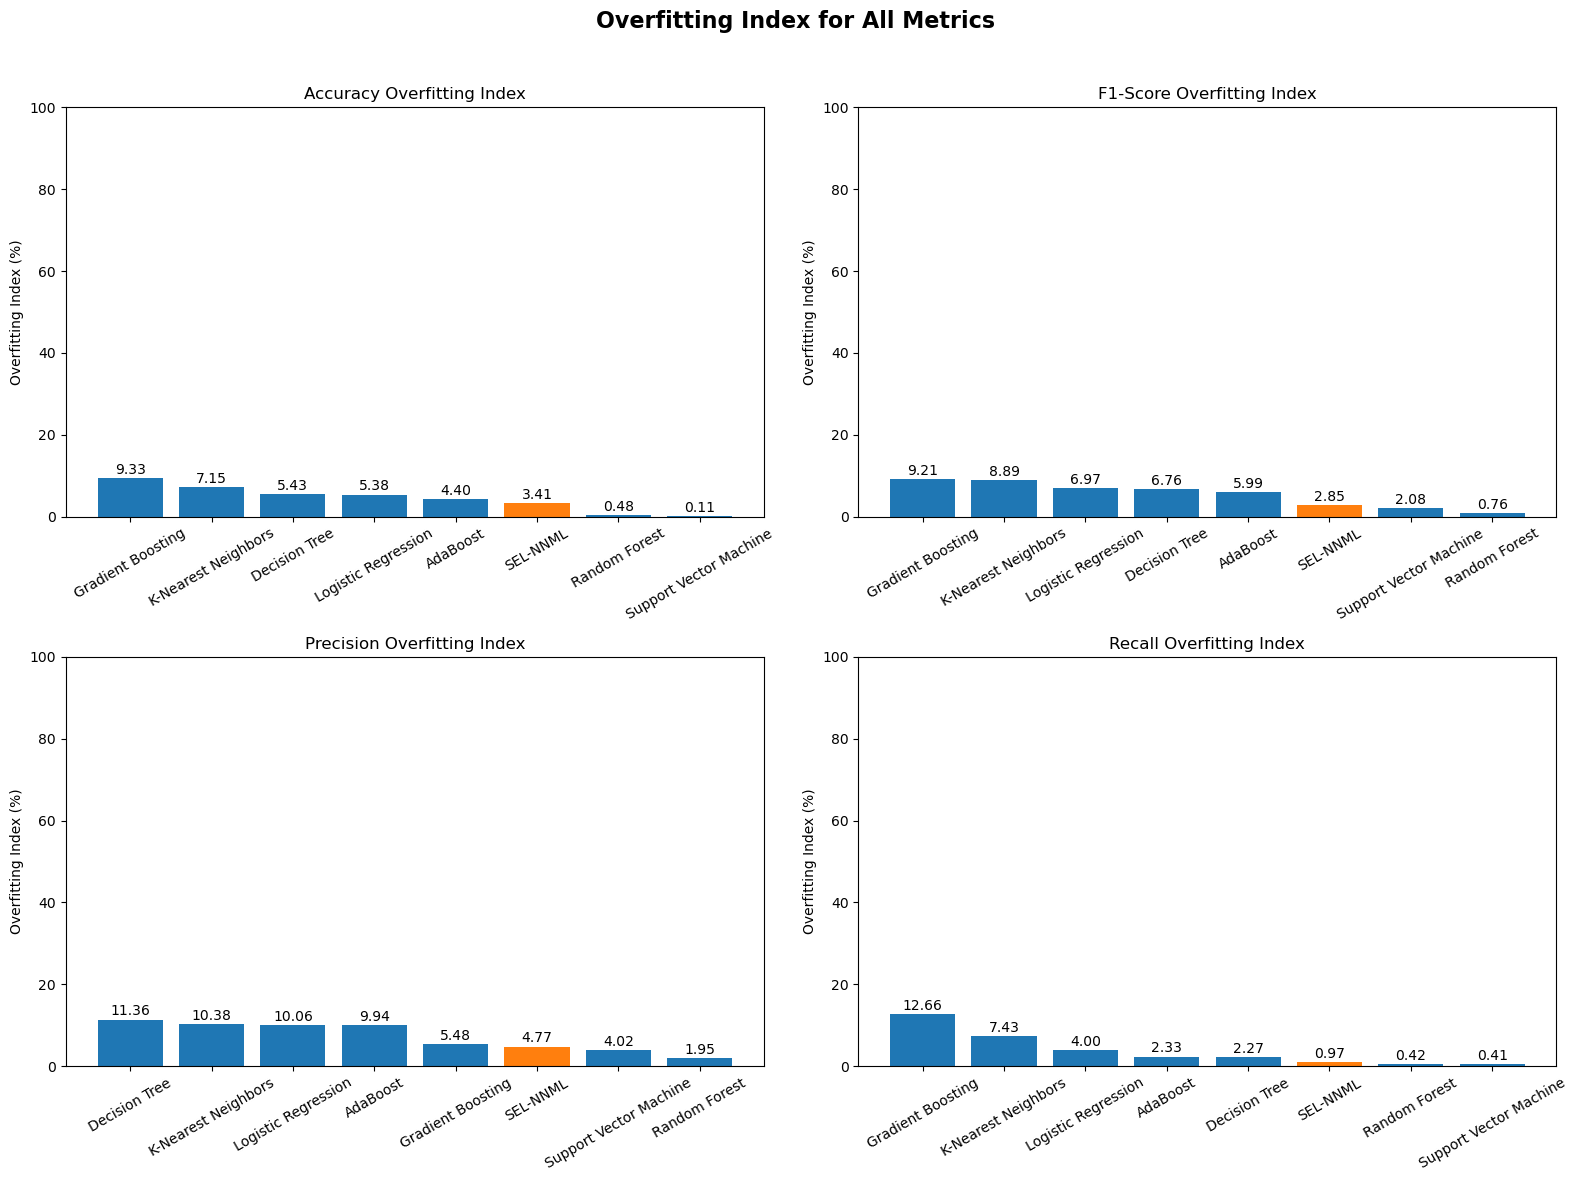

In [212]:
# Use the selected sampler's models for overfitting index comparison
overfitting_index_plot(selected_models, X_train, y_train, X_test, y_test)

In [213]:
# Save feature importance results for all samplers
import os

for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    # Set the sampler
    temp_sampler = sampler
    temp_models = all_models[temp_sampler]
    temp_sel_nnml = temp_models['SEL-NNML']
    
    # Calculate permutation importance for this sampler
    print(f"Calculating feature importance for {temp_sampler}...")
    temp_perm_importance = permutation_importance(
        temp_sel_nnml, X_test, y_test,
        n_repeats=30, random_state=42, n_jobs=-1
    )
    
    # Create dataframe
    temp_importance_df = pd.DataFrame({
        'Feature': X_train.columns.tolist(),
        'Importance Mean': temp_perm_importance.importances_mean,
        'Importance Std': temp_perm_importance.importances_std
    }).sort_values('Importance Mean', ascending=False)
    
    # Save to CSV
    sampler_folder = temp_sampler.lower().replace("-", "")
    os.makedirs(f'../artifacts/ds1/models/{sampler_folder}', exist_ok=True)
    importance_save_path = f'../artifacts/ds1/models/{sampler_folder}/sel-nnml_feature_importance.csv'
    temp_importance_df.to_csv(importance_save_path, index=False)
    print(f"✓ Saved {temp_sampler} feature importance to: {importance_save_path}")

print("\nAll feature importance data saved successfully!")

Calculating feature importance for TPE...
✓ Saved TPE feature importance to: ../artifacts/ds1/models/tpe/sel-nnml_feature_importance.csv
Calculating feature importance for GP...
✓ Saved TPE feature importance to: ../artifacts/ds1/models/tpe/sel-nnml_feature_importance.csv
Calculating feature importance for GP...
✓ Saved GP feature importance to: ../artifacts/ds1/models/gp/sel-nnml_feature_importance.csv
Calculating feature importance for CMA-ES...
✓ Saved GP feature importance to: ../artifacts/ds1/models/gp/sel-nnml_feature_importance.csv
Calculating feature importance for CMA-ES...
✓ Saved CMA-ES feature importance to: ../artifacts/ds1/models/cmaes/sel-nnml_feature_importance.csv
Calculating feature importance for QMC...
✓ Saved CMA-ES feature importance to: ../artifacts/ds1/models/cmaes/sel-nnml_feature_importance.csv
Calculating feature importance for QMC...
✓ Saved QMC feature importance to: ../artifacts/ds1/models/qmc/sel-nnml_feature_importance.csv

All feature importance data sa

### **6.3 Save All Models Metrics (All Samplers)**

This section calculates and saves performance metrics for all models across all samplers. This data will be used for cross-sampler comparisons in the visualization notebook.

In [214]:
# Calculate and save metrics for ALL models from ALL samplers
from sklearn.metrics import roc_curve, auc
import os

print("Calculating metrics for all models across all samplers...")

all_metrics_data = []
all_roc_data = []

for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    print(f"\nProcessing {sampler} models...")
    models = all_models[sampler]
    
    for model_name, model in models.items():
        # Predictions
        y_pred = model.predict(X_test)
        
        # Get probability predictions for AUC and ROC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test)
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Store metrics
        all_metrics_data.append({
            'Sampler': sampler,
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'AUC': roc_auc
        })
        
        # Store ROC curve data
        for f, t in zip(fpr, tpr):
            all_roc_data.append({
                'Sampler': sampler,
                'Model': model_name,
                'FPR': f,
                'TPR': t
            })
        
        print(f"  ✓ {model_name}: Acc={accuracy_score(y_test, y_pred):.4f}, AUC={roc_auc:.4f}")

# Create DataFrames
all_metrics_df = pd.DataFrame(all_metrics_data)
all_roc_df = pd.DataFrame(all_roc_data)

# Save to CSV files
os.makedirs('../artifacts/ds1/models', exist_ok=True)
all_metrics_df.to_csv('../artifacts/ds1/models/all_models_metrics.csv', index=False)
all_roc_df.to_csv('../artifacts/ds1/models/all_models_roc_data.csv', index=False)

print(f"\n✅ Saved metrics for {len(all_metrics_data)} model configurations")
print(f"   - Metrics: ../artifacts/ds1/models/all_models_metrics.csv")
print(f"   - ROC Data: ../artifacts/ds1/models/all_models_roc_data.csv")

# Display summary
print("\n" + "="*80)
print("SUMMARY: Top 5 Models by Accuracy")
print("="*80)
display(all_metrics_df.nlargest(5, 'Accuracy')[['Sampler', 'Model', 'Accuracy', 'F1-Score', 'AUC']])

Calculating metrics for all models across all samplers...

Processing TPE models...
  ✓ Logistic Regression: Acc=0.9000, AUC=0.9531
  ✓ Decision Tree: Acc=0.8933, AUC=0.9354
  ✓ Random Forest: Acc=0.9000, AUC=0.9563
  ✓ K-Nearest Neighbors: Acc=0.9133, AUC=0.9508
  ✓ Support Vector Machine: Acc=0.8600, AUC=0.9594
  ✓ AdaBoost: Acc=0.8933, AUC=0.9640
  ✓ Gradient Boosting: Acc=0.9067, AUC=0.9656
  ✓ AdaBoost: Acc=0.8933, AUC=0.9640
  ✓ Gradient Boosting: Acc=0.9067, AUC=0.9656
  ✓ SEL-NNML: Acc=0.9400, AUC=0.9631

Processing GP models...
  ✓ Logistic Regression: Acc=0.8933, AUC=0.9513
  ✓ Decision Tree: Acc=0.8933, AUC=0.9354
  ✓ Random Forest: Acc=0.8867, AUC=0.9540
  ✓ SEL-NNML: Acc=0.9400, AUC=0.9631

Processing GP models...
  ✓ Logistic Regression: Acc=0.8933, AUC=0.9513
  ✓ Decision Tree: Acc=0.8933, AUC=0.9354
  ✓ Random Forest: Acc=0.8867, AUC=0.9540
  ✓ K-Nearest Neighbors: Acc=0.9133, AUC=0.9495
  ✓ Support Vector Machine: Acc=0.8600, AUC=0.9595
  ✓ AdaBoost: Acc=0.8800, AUC=0.

,Sampler,Model,Accuracy,F1-Score,AUC
7,TPE,SEL-NNML,0.940000,0.942675,0.963095
15,GP,SEL-NNML,0.926667,0.930818,0.954181
23,CMA-ES,SEL-NNML,0.926667,0.929936,0.960956
31,QMC,SEL-NNML,0.920000,0.927711,0.961669
3,TPE,K-Nearest Neighbors,0.913333,0.917197,0.950793
